# Verify Positional Encoding Fix for TransformerTimeSeries
This notebook helps validate the corrected PositionalEncoding in your model and ensures end-to-end shape correctness.

## 1. Imports and Setup

In [1]:
from pathlib import Path

def find_project_root(marker=".gitignore"):
    """
    walk up from the current working directory until a directory containing the
    specified marker (e.g., .gitignore) is found.
    """
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / marker).exists():
            return parent.resolve()
    raise FileNotFoundError(
        f"Project root marker '{marker}' not found starting from {current}"
    )
root = find_project_root()

In [2]:
import sys
sys.path.append(f"{root}/final_dataset_scripts")
import torch
import matplotlib.pyplot as plt
from architectures import PositionalEncoding, TransformerTimeSeries, AttentionPooling
from torch.utils.data import DataLoader
from custom_dataset import SepsisPatientDataset, collate_fn


## 2. Test PositionalEncoding Behavior

All time steps identical?: False


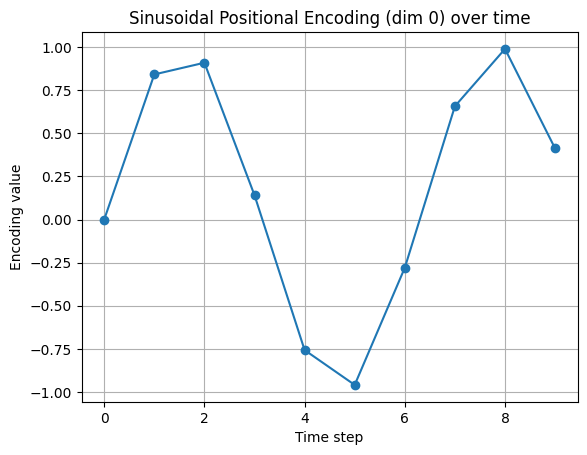

In [3]:
# Instantiate positional encoding
d_model = 64
pe = PositionalEncoding(d_model=d_model)

# Create dummy inputs
seq_len, batch_size = 10, 3
dummy_x = torch.zeros(seq_len, batch_size, d_model)

# Apply positional encoding
pe_out = pe(dummy_x)

# Verify that different time steps have different encodings
print("All time steps identical?:", torch.allclose(pe_out[0], pe_out[1]))

# Plot first dimension of positional encodings for first seq_len steps
pos_vals = pe.pe[0, :seq_len, 0].cpu().numpy()
plt.plot(range(seq_len), pos_vals, marker='o')
plt.title("Sinusoidal Positional Encoding (dim 0) over time")
plt.xlabel("Time step")
plt.ylabel("Encoding value")
plt.grid(True)
plt.show()


## 3. Load a Small Sample of Your Data
Replace the placeholder code below with the actual path to your dataset.

In [4]:
root

PosixPath('/Users/aidend/Developer/ds_uni/dl-sepsis-prediction')

In [5]:
sys.path

['/opt/homebrew/anaconda3/lib/python312.zip',
 '/opt/homebrew/anaconda3/lib/python3.12',
 '/opt/homebrew/anaconda3/lib/python3.12/lib-dynload',
 '',
 '/Users/aidend/Developer/ds_uni/dl-sepsis-prediction/.venv/lib/python3.12/site-packages',
 '/Users/aidend/Developer/ds_uni/dl-sepsis-prediction/final_dataset_scripts']

In [6]:
import os
import sys
print(sys.path[-1])
print(os.listdir(sys.path[-1]))

/Users/aidend/Developer/ds_uni/dl-sepsis-prediction/final_dataset_scripts
['final_dataset_processing.ipynb', '__init__.py', '__pycache__', 'README.md', 'dataset_loader.py']


In [7]:
# TODO: Update the CSV path and column names as needed
import pandas as pd
import sys


from dataset_loader import load_train_data
train_data = load_train_data("undersampled")

data = train_data['X'].values
labels = train_data['y'].values
patient_ids = train_data['patient_ids'].values
time_index = train_data['X'].columns.get_loc('ICULOS')

# For demonstration, we use random data:
num_samples = 100
seq_len = 8
feature_dim = 5
data = torch.randn(num_samples * seq_len, feature_dim).numpy()
labels = (torch.rand(num_samples * seq_len) > 0.8).int().numpy()
patient_ids = [f"P{idx//seq_len}" for idx in range(num_samples * seq_len)]
time_index = 0  # assume first feature is time

# Build dataset and loader
dataset = SepsisPatientDataset(data, labels, patient_ids, time_index)
loader = DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
print(f"Dataset has {len(dataset)} patients, first batch will be size 4.")


Dataset has 100 patients, first batch will be size 4.


## 4. Forward Pass Through TransformerTimeSeries

In [8]:
# Instantiate model with matching input_dim and d_model
model = TransformerTimeSeries(input_dim=feature_dim, d_model=d_model, n_heads=2, n_layers=2, dropout=0.1)
model.eval()

# Fetch one batch
for X_batch, y_batch, attention_mask in loader:
    print("X_batch shape (seq_len, batch, feature_dim):", X_batch.shape)
    print("y_batch shape (batch,):", y_batch.shape)
    print("attention_mask shape (seq_len, batch):", attention_mask.shape)
    
    # Forward pass
    with torch.no_grad():
        logits = model(X_batch, mask=attention_mask)
        print("Logits shape (batch,):", logits.shape)
    break


X_batch shape (seq_len, batch, feature_dim): torch.Size([8, 4, 5])
y_batch shape (batch,): torch.Size([4])
attention_mask shape (seq_len, batch): torch.Size([8, 4])


/Users/aidend/Developer/ds_uni/dl-sepsis-prediction/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Logits shape (batch,): torch.Size([4])


## 5. Optional: Test Attention Pooling Integration

In [9]:
# Replace mean pooling with attention pooling to see behavior
pool = AttentionPooling(d_model=d_model)

for X_batch, y_batch, attention_mask in loader:
    # Run embedding -> encoder only
    x_emb = model.embedding(X_batch)
    x_pos = model.positional_encoder(x_emb)
    mask_proc = ~attention_mask.bool()
    mask_proc = mask_proc.transpose(0,1)
    x_enc = model.encoder(x_pos, src_key_padding_mask=mask_proc)
    
    # Apply attention pooling
    pooled = pool(x_enc, attention_mask)
    print("Pooled shape (batch, d_model):", pooled.shape)
    # Project to logits
    logits_attn = model.linear_layer(pooled).squeeze(-1)
    print("Attention-pooled logits shape:", logits_attn.shape)
    break

Pooled shape (batch, d_model): torch.Size([4, 64])
Attention-pooled logits shape: torch.Size([4])
